Importando libs necessárias para o projeto.

In [105]:
import pandas as pd
import seaborn as sn
import numpy as np 
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
from urllib.request import urlretrieve
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
import seaborn as sns
import random
import pickle
from xgboost               import XGBClassifier 
from lightgbm              import LGBMClassifier
from scipy   import stats           as ss
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh
from sklearn.multiclass      import OneVsRestClassifier
from sklearn.metrics       import f1_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import sweetviz as sv
from imblearn.over_sampling  import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

In [94]:
def personal_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['font.size'] = 20
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x:'%.2f' % x)
    sns.set()
    sns.set(rc = {'figure.figsize':(12,6)})
    warnings.filterwarnings('ignore')

personal_settings()

Lendo os dados do datasets e transformando em um dataframe

In [2]:
df_treino = pd.read_csv("datasets/desafio_manutencao_preditiva_treino.csv")
df_teste = pd.read_csv("datasets/desafio_manutencao_preditiva_teste.csv")

In [57]:
df_treino.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,298.1,308.6,1551,42.8,0,0
1,0,298.2,308.7,1408,46.3,3,0
2,0,298.2,308.7,1408,40.0,9,0
3,1,298.1,308.6,1425,41.9,11,0
4,0,298.1,308.6,1558,42.4,14,0


In [58]:
df_teste.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,446,L47625,L,297.5,308.6,1793,26.7,70
1,7076,L54255,L,300.7,310.5,1536,47.4,192
2,1191,L48370,L,297.2,308.4,1460,42.1,41
3,2618,L49797,L,299.4,309.1,1670,35.9,68
4,5067,L52246,L,304.1,313.1,1550,30.9,9


In [59]:
df_treino['failure_type']

0       0
1       0
2       0
3       0
4       0
       ..
6662    0
6663    0
6664    0
6665    0
6666    0
Name: failure_type, Length: 6667, dtype: int64

Analisando os dados de Treino

In [3]:
df_treino

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure
...,...,...,...,...,...,...,...,...,...
6662,9995,L57174,L,298.8,308.3,1634,27.9,12,No Failure
6663,9996,M24855,M,298.8,308.4,1604,29.5,14,No Failure
6664,9997,H39410,H,298.9,308.4,1632,31.8,17,No Failure
6665,9999,H39412,H,299.0,308.7,1408,48.5,25,No Failure


Informações básicas do dataset, assim como valores não nulos

In [5]:
print(df_treino.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   object 
 2   type                   6667 non-null   object 
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   failure_type           6667 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 468.9+ KB
None


Verifica se existem dados nulos ou duplicado

In [8]:
print('Nulos')
print(df_treino.isnull().sum())
print(32 * '-')
print('Duplicados')
print(df_treino.duplicated().sum())

Nulos
udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64
--------------------------------
Duplicados
0


# Análise exploratória
Estatisticas básicas em relação aos dados

In [10]:
df_treino.describe().T

,count,mean,std,min,25%,50%,75%,max
udi,6667.0,4994.589921,2896.125718,1.0,2496.5,4983.0,7510.5,10000.0
air_temperature_k,6667.0,299.992515,1.994710,295.3,298.3,300.0,301.5,304.5
process_temperature_k,6667.0,309.992620,1.488101,305.7,308.8,310.0,311.1,313.8
rotational_speed_rpm,6667.0,1537.419529,177.182908,1168.0,1422.5,1503.0,1612.0,2886.0
torque_nm,6667.0,40.058512,9.950804,3.8,33.2,40.2,46.8,76.6
tool_wear_min,6667.0,108.098095,63.359915,0.0,54.0,108.0,162.0,251.0


- Plotando a frequência dos tipos de falhas em um gráfico (histograma)
- É notável a quantidade de observações da variável plotada, sendo assim, o tipo de falha mais
frequente e as demais em ordem decrescente 

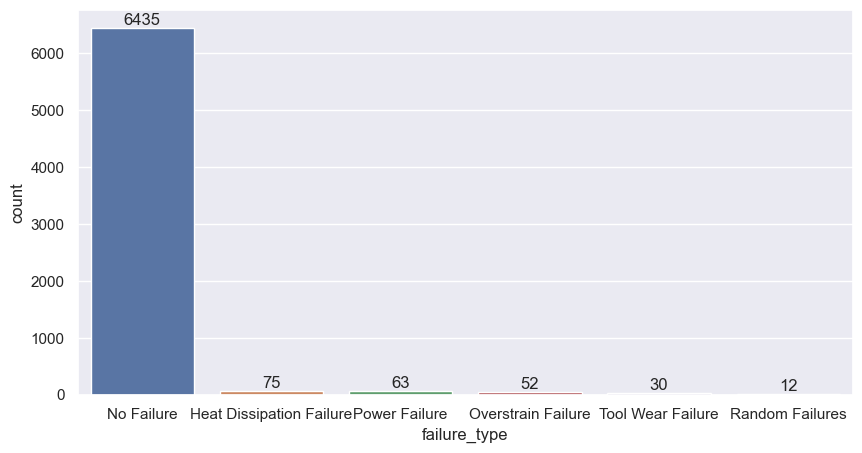

In [13]:
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.countplot(data=df_treino, x='failure_type', order=df_treino['failure_type'].value_counts(ascending=False).index)
ax.bar_label(ax.containers[0])
plt.show()

Analisando a distribuição das variáveis

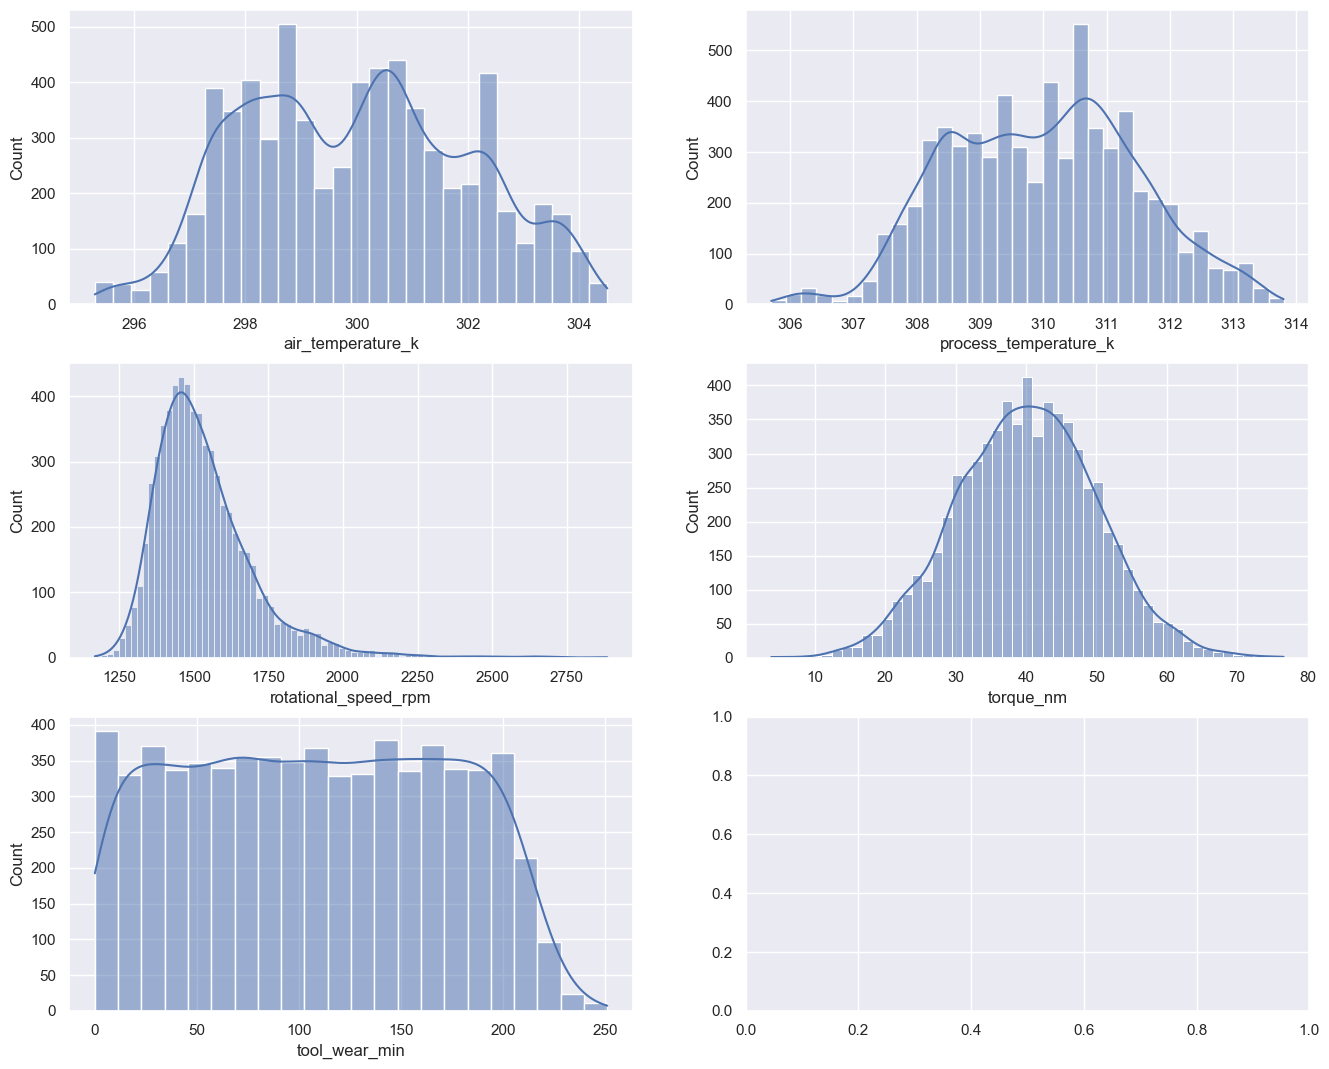

In [16]:
fig, axs = plt.subplots(figsize=(16,13), ncols=2, nrows=3)

sns.histplot(x=df_treino.air_temperature_k, kde=True, ax=axs[0][0])
sns.histplot(x=df_treino.process_temperature_k, kde=True, ax=axs[0][1])
sns.histplot(x=df_treino.rotational_speed_rpm, kde=True, ax=axs[1][0])
sns.histplot(x=df_treino.torque_nm, kde=True, ax=axs[1][1])
sns.histplot(x=df_treino.tool_wear_min, kde=True, ax=axs[2][0])

plt.show()

Quantidade de Produto por tipo
- a maior quantidade de tipo de produto é do tipo L com 59,3% dos dados, seguido do tipo M com 30,3% dos dados

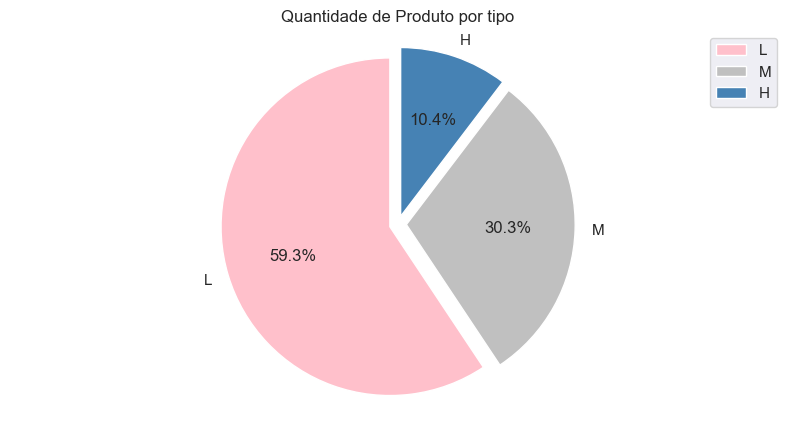

In [17]:
labels = ['L', 'M', 'H']
values = [df_teste['type'].value_counts()[0], df_teste['type'].value_counts()[1], df_teste['type'].value_counts()[2]]
colors = ['pink', 'silver', 'steelblue']
explode = (0.05, 0.05, 0.05)
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle = 90, explode=explode)
plt.title('Quantidade de Produto por tipo')
plt.axis('equal')
plt.legend()
plt.show()

Quantidade de Falha por tipo
- Tipos de falhas existentes na base de dados
- Quantidade de falhas existentes por tipo

In [18]:
df_treino['failure_type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [19]:
df_treino["failure_type"].value_counts()

No Failure                  6435
Heat Dissipation Failure      75
Power Failure                 63
Overstrain Failure            52
Tool Wear Failure             30
Random Failures               12
Name: failure_type, dtype: int64

Tipos de falhas ocorridas no conjunto de dados

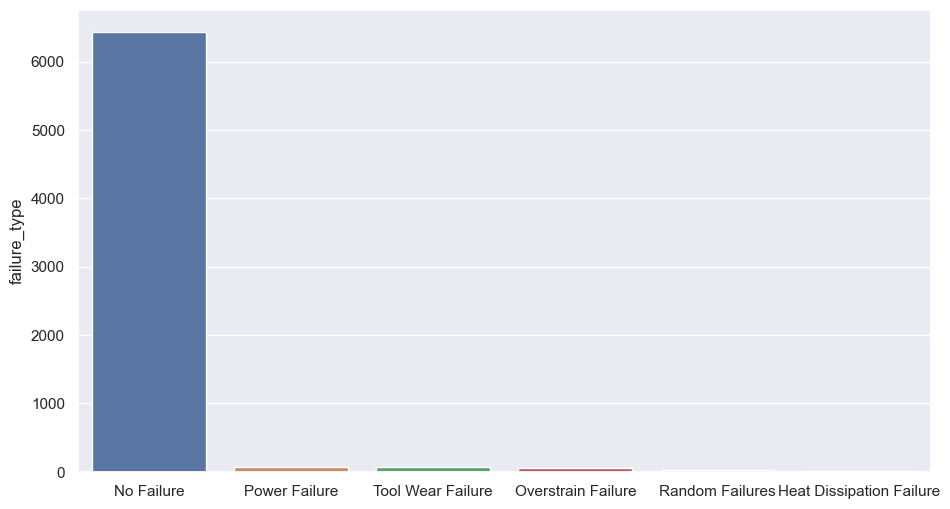

In [20]:
values = df_treino["failure_type"].value_counts()
labels = ["No Failure", 'Power Failure', 'Tool Wear Failure', 'Overstrain Failure',
         'Random Failures', 'Heat Dissipation Failure']

plt.figure(figsize=(11, 6))

sn.barplot(x = labels,
            y = values)
 
plt.show()

Gráfico de calor para mostrar as correlações entre todas as variáveis
- Observação: Quanto mais intensa é a cor e mais próximo de 1 ou -1, maior é a correlação entre as variáveis

<AxesSubplot:>

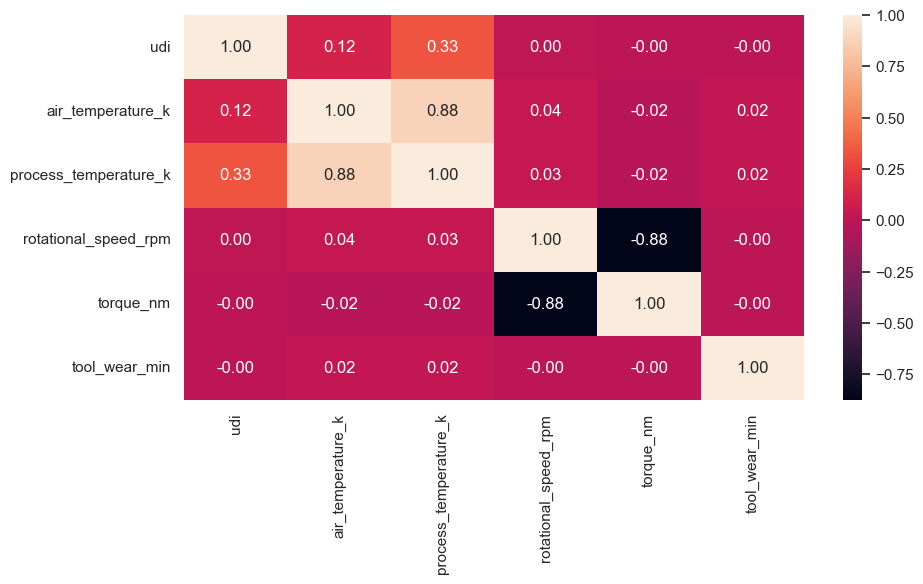

In [21]:
sns.heatmap(df_treino.corr(), annot = True, fmt = ".2f")

Variáveis Categóricas
- A maioria dos produtos produzidos pelas máquinas são do tipo 'L', e a minoria são do tipo 'H'.

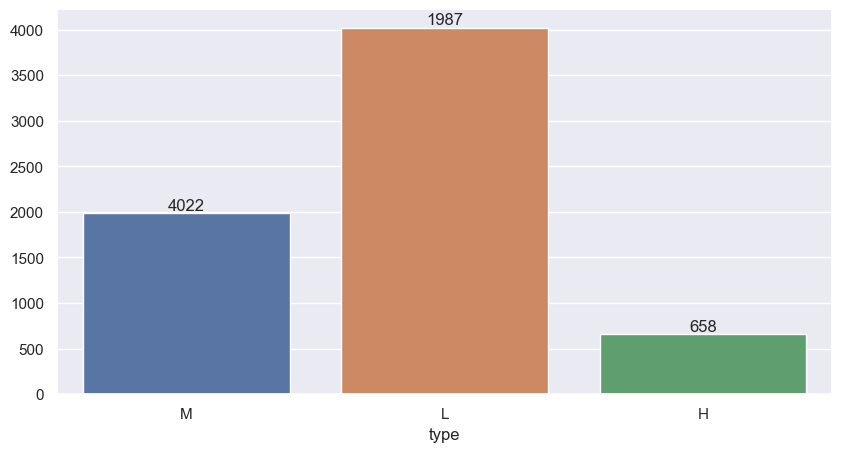

In [22]:
a = sns.countplot(x='type', data=df_treino)
values = df_treino['type'].value_counts().values
a.bar_label(container=a.containers[0], labels=values)
a.set(ylabel=None);

Criando um dicionário para transformar a variável 'failure_type' em numérica, para ser incluída no modelo

In [31]:
dicionario_failure_type = {'No Failure': 0,
            'Heat Dissipation Failure': 1,
            'Power Failure': 2,
            'Overstrain Failure': 3,
            'Tool Wear Failure': 4,
            'Random Failures': 5}
df_treino['failure_type'] = df_treino.failure_type.map(dicionario_failure_type)
df_treino.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0
2,5,L47184,L,298.2,308.7,1408,40.0,9,0
3,6,M14865,M,298.1,308.6,1425,41.9,11,0
4,7,L47186,L,298.1,308.6,1558,42.4,14,0


Criando um dicionário para transformar a variável 'type' em numérica, para ser incluída no modelo

In [32]:
dicionario_type = {'L': 0,
              'M': 1,
              'H': 2}
df_treino['type'] = df_treino.type.map(dicionario_type)
df_treino.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,1,298.1,308.6,1551,42.8,0,0
1,2,L47181,0,298.2,308.7,1408,46.3,3,0
2,5,L47184,0,298.2,308.7,1408,40.0,9,0
3,6,M14865,1,298.1,308.6,1425,41.9,11,0
4,7,L47186,0,298.1,308.6,1558,42.4,14,0


Selecionando as colunas das variáveis a serem usadas no modelo, excluindo 'udi', 'product_id', 'failure_type'

In [33]:
df_treino = df_treino[['type', 'air_temperature_k','process_temperature_k', 'rotational_speed_rpm', 'torque_nm','tool_wear_min', 
        'failure_type']]
display(df_treino.head(5))

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,298.1,308.6,1551,42.8,0,0
1,0,298.2,308.7,1408,46.3,3,0
2,0,298.2,308.7,1408,40.0,9,0
3,1,298.1,308.6,1425,41.9,11,0
4,0,298.1,308.6,1558,42.4,14,0


Gráficos de dispersão das variáveis mais correlacionadas, por tipo de falha

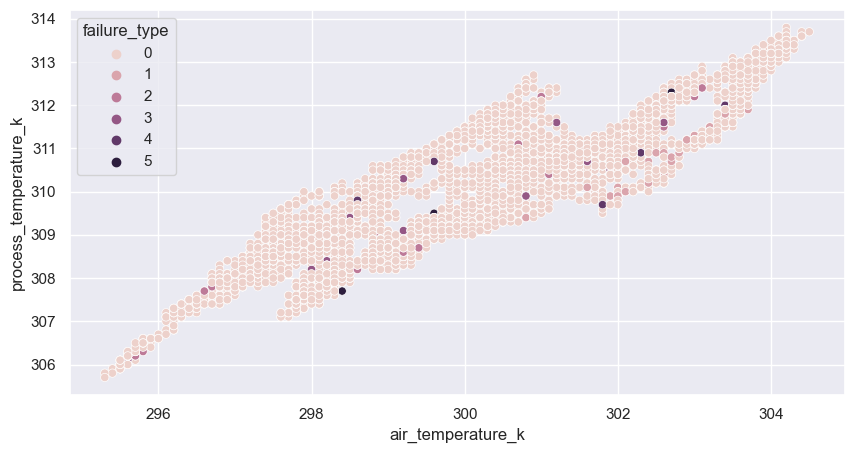

In [34]:
sns.scatterplot(x='air_temperature_k', y='process_temperature_k', data=df_treino, hue='failure_type')
plt.show()

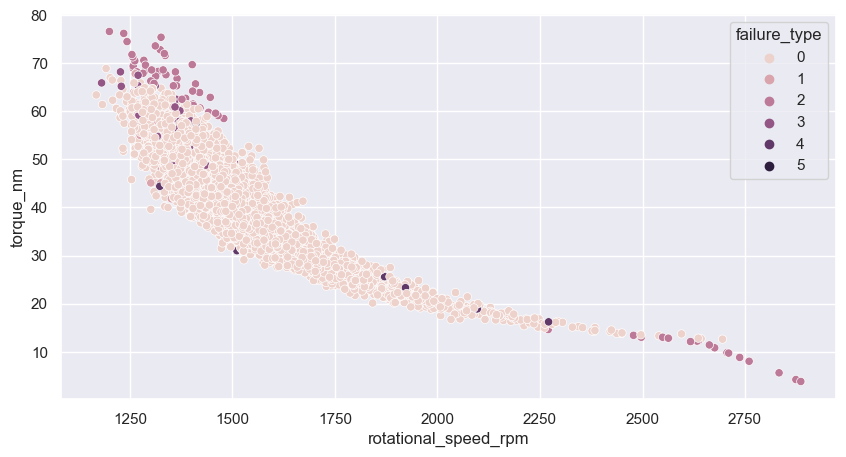

In [35]:
sns.scatterplot(x='rotational_speed_rpm', y='torque_nm', data=df_treino, hue='failure_type')
plt.show()

Gerando boxplot das colunas do conjunto de treino para auxiliar na análise exploratória de dados e na verificação da existência de outliers.

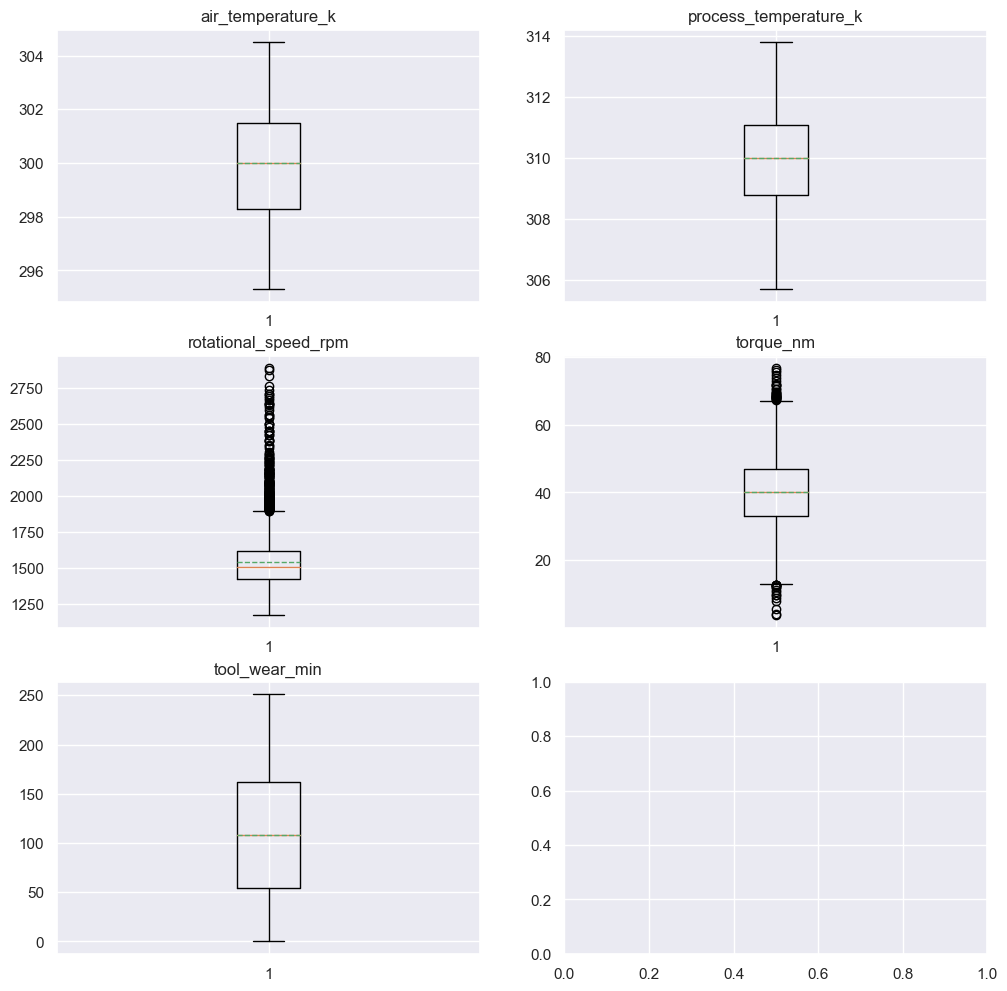

In [36]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharey=False)
axs[0, 0].boxplot(df_treino['air_temperature_k'], showmeans=True, meanline=True)
axs[0, 0].set_title('air_temperature_k')

axs[0, 1].boxplot(df_treino['process_temperature_k'], showmeans=True, meanline=True)
axs[0, 1].set_title('process_temperature_k')

axs[1, 0].boxplot(df_treino['rotational_speed_rpm'], showmeans=True, meanline=True)
axs[1, 0].set_title('rotational_speed_rpm')

axs[1, 1].boxplot(df_treino['torque_nm'], showmeans=True, meanline=True)
axs[1, 1].set_title('torque_nm')

axs[2, 0].boxplot(df_treino['tool_wear_min'], showmeans=True, meanline=True)
axs[2, 0].set_title('tool_wear_min')

plt.show()

Gerando histograma das colunas do conjunto de treino para auxiliar na verificação do tipo de distribuição dos dados

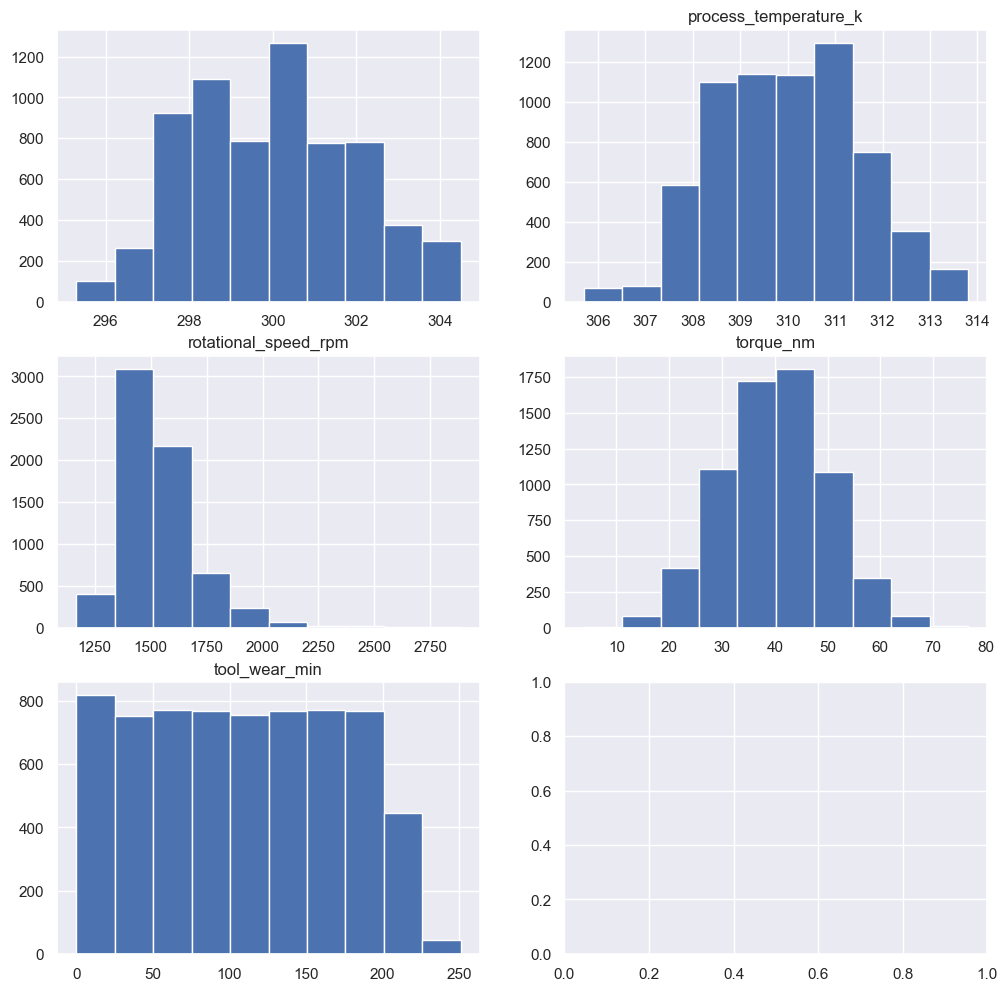

In [37]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharey=False)
axs[0, 0].hist(df_treino['air_temperature_k'], )
axs[0, 0].set_title, 

axs[0, 1].hist(df_treino['process_temperature_k'])
axs[0, 1].set_title('process_temperature_k')

axs[1, 0].hist(df_treino['rotational_speed_rpm'])
axs[1, 0].set_title('rotational_speed_rpm')

axs[1, 1].hist(df_treino['torque_nm'])
axs[1, 1].set_title('torque_nm')

axs[2, 0].hist(df_treino['tool_wear_min'])
axs[2, 0].set_title('tool_wear_min')

plt.show()

Correlação entre features
- A feature (air_temperature_k) relaciona-se fortemente com a feature (process_temperature_k) proporcionalmente
- Encontra-se forte correlação inversamente proporcional (valores próximos de -1) entre as variáveis (rotacional_speed_rpm) e (torque_nm) observando, no entanto, que o aumento de uma corresponde na diminuição da outra

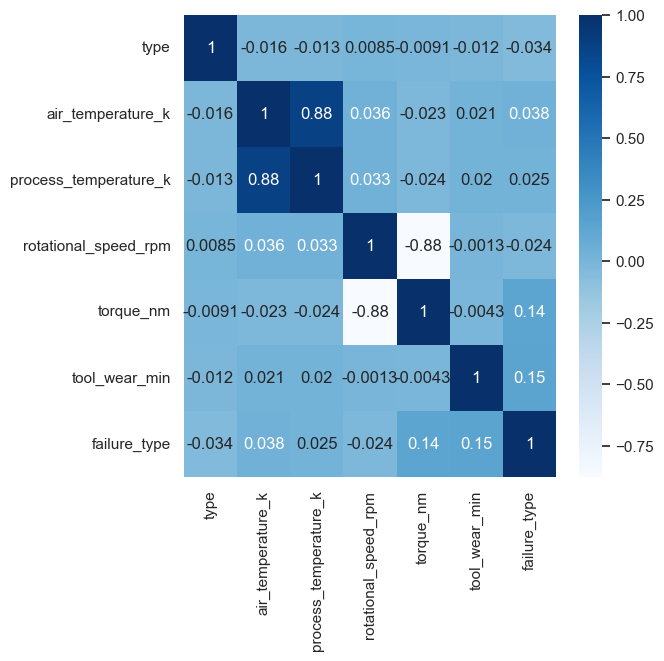

In [51]:
plt.figure (figsize = (6,6))
sns.heatmap(df_treino.corr(),annot=True, cmap='Blues')
plt.show()

In [55]:
type(df_treino)

pandas.core.frame.DataFrame

In [56]:
type(df_teste)

pandas.core.frame.DataFrame

Logo abaixo, um modelo de funções auxiliares.

In [63]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n) / ( min( kcorr-1, rcorr-1 )))

def resultssp(y_val, yhat, model_name):
    
    # precision
    precision = precision_score(y_val, yhat, zero_division=1)
    # recall
    recall = recall_score(y_val, yhat, zero_division='warn')
    # f1 score
    f1 = f1_score(y_val, yhat, zero_division='warn')
    # balanced accuracy
    bas = balanced_accuracy_score(y_val, yhat)
    
    return pd.DataFrame({'Precision': precision, 
                         'Recall': recall,
                         'F1-Score': f1,
                         'Balanced Accuracy': bas}, index=[model_name])


def cross_validation(model_name, model, x_train, y_train, verbose=False):
    precision_list = []
    recall_list = []
    f1_list = []
    bas_list = []
    
    kfs = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    
    for cv_train, cv_val in kfs.split(x_train, y_train):
        
        xtrain_val = x_train.iloc[cv_train]
        ytrain_val = y_train.iloc[cv_train]
        
        xval = x_train.iloc[cv_val]
        yval = y_train.iloc[cv_val]
        
        # model
        model.fit(xtrain_val, ytrain_val)

        # prediction
        yhat = model.predict(xval)
        
        # training and validation dataset
        data = xval.copy()
        data['failure_type'] = yval.copy()

        # performance
        precision_v = precision_score(yval, yhat)
        precision_list.append(precision_v)
        
        recall_v = recall_score(yval, yhat)
        recall_list.append(recall_v)
        
        f1_v = f1_score(yval, yhat)
        f1_list.append(f1_v)
        
        bas_v = balanced_accuracy_score(yval, yhat)
        bas_list.append(bas_v) 
        
        
    return pd.DataFrame({'Precision CV': np.round(np.mean(precision_list), 3),
                         'Recall CV': np.round(np.mean(recall_list), 3),
                         'F1-Score CV': np.round(np.mean(f1_list), 3),
                         'Balanced Accuracy CV': np.round(np.mean(bas_list), 3)},index=[model_name])

In [95]:
def failure_rate(df, atribute):
  '''Função usada na etapa de validação de hipóteses, para calcular o percentual de falha em razão de algum atributo do conjunto de dados'''
  df_result = pd.DataFrame()

  for i in df[atribute].unique():
    mask_i = df[atribute] == i
    maskf = df['result'] == 'failure'
    masknf = df['result'] == 'no_failure'
    failure = (df[mask_i & maskf].shape[0] / df[mask_i & masknf].shape[0]) * 100

    df_temp = pd.DataFrame({atribute: i, 
              'failure_rate (%)': failure}, index=[0])
    df_result = pd.concat([df_result, df_temp])

  df_result = df_result.sort_values('failure_rate (%)', ascending=False)
  
  return df_result


def model_avaliation(data, y_hat, y_val, model_name):
    '''Função para preparar os dados, calcular o precision, recall, f1-score e accuracy do modelo e retornar os valores em um dataframe'''
    df = data.copy()
    df['classification'] = y_hat.tolist()
    
    precision = precision_score(y_val, y_hat, average='macro')
    recall = recall_score(y_val, y_hat, average='macro')
    f1score = f1_score(y_val, y_hat, average='macro')
    accuracy = accuracy_score(y_val, y_hat)
    
    return pd.DataFrame({'Precision': precision,
                        'Recall': recall,
                        'F1-Score': f1score,
                        'Accuracy': accuracy}, index=[model_name])

def cross_validation(model_name, model, x_train, y_train, oversample=False, verbose=False):
    '''Função para realizar o Cross Validation dos modelos de Machine Learning sobre dados desbalanceados ou balanceados'''
    precision_list = []
    recall_list    = []
    f1_list        = []
    
    kfolds = StratifiedKFold(n_splits = 5, shuffle=True, random_state=5)
    
    for cv_train, cv_val in kfolds.split(x_train, y_train):
        
        # Cross-Validation Train
        xtrain_val = x_train.iloc[cv_train]
        ytrain_val = y_train.iloc[cv_train]
        
        # Cross-Validation Validation
        xval = x_train.iloc[cv_val]
        yval = y_train.iloc[cv_val]
        
        if oversample == True: 
          oversample = SMOTE()
          x_train_over, y_train_over = oversample.fit_resample(xtrain_val, ytrain_val)
          # Treinamento do modelo sobre dados balanceados
          model.fit(x_train_over, y_train_over)

        else: 
          # Treinamento do modelo sobre dados desbalanceados
          model.fit(xtrain_val, ytrain_val)

        # Previsão
        yhat = model.predict(xval)
        
        # Preparando os Dados
        data = xval.copy()
        data['failure_type'] = yval.copy()

        # Score
        data['classification'] = yhat.tolist()

        # Performance
        precision = precision_score(yval, yhat, average='macro')
        precision_list.append(precision)
        
        recall = recall_score(yval, yhat, average='macro')
        recall_list.append(recall)

        f1score = f1_score(yval, yhat, average='macro')
        f1_list.append(f1score)
        
        acc = accuracy_score(yval, yhat)
        
    return pd.DataFrame({'Precision - CV': np.round(np.mean(precision_list), 3),
                         'Recall - CV': np.round(np.mean(recall_list), 3),
                         'F1-Score - CV': np.round(np.mean(f1_list), 3),
                         'Accuracy - CV': np.round(np.mean(acc), 3)},index=[model_name])

In [66]:
cols_selected = ['torque_nm', 'rotational_speed_rpm', 'tool_wear_min', 'air_temperature_k', 'process_temperature_k']

In [71]:
# Treino e teste
x = df_treino.drop(columns=['failure_type'], axis=1)
y = df_treino['failure_type'].copy()

x_traint, x_validation, y_traint, y_validation = ms.train_test_split(x, y, test_size= 0.20)

df_treino = pd.concat([x_traint , y_traint], axis=1)

Preparando os Dados

In [133]:
x_train = df_treino[cols_selected]
x_train.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
2261,301.70,310.80,1671,31.60,137
838,297.50,308.80,1309,57.30,0
4629,300.70,311.20,1769,26.50,63
4091,301.00,310.90,1575,34.60,150
879,299.00,310.30,1635,34.50,168


In [134]:
y_train = df_treino['failure_type'].copy()
y_train.head()

2261    0
838     0
4629    0
4091    0
879     0
Name: failure_type, dtype: int64

In [81]:
x_val = x_validation[cols_selected]
x_val.head()

,torque_nm,rotational_speed_rpm,tool_wear_min,air_temperature_k,process_temperature_k
3852,21.5,1907,102,301.6,311.1
1127,41.6,1509,33,298.0,307.6
1651,37.6,1555,142,298.9,308.5
3438,12.7,2643,21,304.3,313.5
640,54.8,1287,49,295.6,306.2


In [82]:
y_val = y_validation.copy()
y_val.head()

3852    0
1127    0
1651    0
3438    0
640     0
Name: failure_type, dtype: int64

In [73]:
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = df_treino.drop('failure_type', axis=1)
y_train_n = y_traint.values
forest.fit (x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Modelo de Machine Learning
- LGBM Classifier

In [74]:
x_train = df_teste[cols_selected]
y_train = y_traint.copy()

x_val = x_validation[cols_selected]
y_val = y_validation.copy()

In [75]:
df_teste = x_validation.copy()
df_teste['failure_type'] = y_validation.copy() 

In [85]:
# Modelo
lgbm_model = OneVsRestClassifier(LGBMClassifier(class_weight='balanced'))
# Treinamento
lgbm_model.fit(x_train, y_train)
# Previsão
yhat_lgbm = lgbm_model.predict(x_val)

- Definindo alguns valores de parâmetros aleatórios
- Quantas vezes serão combinados para treinamento do algoritmo

In [100]:
param = {'num_leaves': [35, 40, 65],
         'max_depth': [-1, 3, 5, 9],
         'n_estimators': [50, 100, 200, 350],
         'min_child_weight': [3, 8, 15], 
         'min_child_samples': [20, 30, 40],
         'colsample_bytree': [0.3, 0.7, 0.9]
}

max_iterations = 10

Criando um loop for para treinar o modelo com as diferentes combinações de valores para os parâmetros.

In [106]:
final_result = pd.DataFrame()

for i in range(max_iterations):
    
    # Escolhendo o conjunto de valores aleatoriamente
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)

    # Criando o modelo    
    model_lgbm = OneVsRestClassifier(LGBMClassifier(
                                   num_leaves = hp['num_leaves'],
                                   max_depth = hp['max_depth'],
                                   n_estimators = hp['n_estimators'],
                                   min_child_weight = hp['min_child_weight'],
                                   min_child_samples = hp['min_child_samples'],
                                   colsample_bytree = hp['colsample_bytree']
                                   ))
    
    # Verificando a perfomance com Cross-Validation
    result = cross_validation('LGBMClassifier', model_lgbm, x_train, y_train)

    # Criando o dataframe para comparação de métricas de performance
    final_result = pd.concat([final_result, result])

{'num_leaves': 40, 'max_depth': 9, 'n_estimators': 350, 'min_child_weight': 15, 'min_child_samples': 40, 'colsample_bytree': 0.3}
{'num_leaves': 35, 'max_depth': 3, 'n_estimators': 200, 'min_child_weight': 15, 'min_child_samples': 40, 'colsample_bytree': 0.3}
{'num_leaves': 40, 'max_depth': 5, 'n_estimators': 350, 'min_child_weight': 8, 'min_child_samples': 20, 'colsample_bytree': 0.7}
{'num_leaves': 35, 'max_depth': 9, 'n_estimators': 200, 'min_child_weight': 3, 'min_child_samples': 30, 'colsample_bytree': 0.3}
{'num_leaves': 40, 'max_depth': 9, 'n_estimators': 200, 'min_child_weight': 8, 'min_child_samples': 30, 'colsample_bytree': 0.7}
{'num_leaves': 65, 'max_depth': -1, 'n_estimators': 100, 'min_child_weight': 15, 'min_child_samples': 20, 'colsample_bytree': 0.7}
{'num_leaves': 40, 'max_depth': 9, 'n_estimators': 100, 'min_child_weight': 3, 'min_child_samples': 30, 'colsample_bytree': 0.3}
{'num_leaves': 35, 'max_depth': 5, 'n_estimators': 200, 'min_child_weight': 3, 'min_child_sam

In [107]:
final_result

,Precision - CV,Recall - CV,F1-Score - CV,Accuracy - CV
LGBMClassifier,0.18,0.19,0.18,0.97
LGBMClassifier,0.18,0.19,0.18,0.97
LGBMClassifier,0.18,0.19,0.18,0.97
LGBMClassifier,0.33,0.27,0.29,0.97
LGBMClassifier,0.18,0.19,0.18,0.97
LGBMClassifier,0.18,0.19,0.18,0.97
LGBMClassifier,0.24,0.23,0.23,0.98
LGBMClassifier,0.29,0.24,0.26,0.97
LGBMClassifier,0.18,0.19,0.18,0.97
LGBMClassifier,0.18,0.19,0.18,0.97


In [108]:
best_params = {'num_leaves': 35, 'max_depth': 9, 'n_estimators': 200, 'min_child_weight': 3, 'min_child_samples': 20, 'colsample_bytree': 0.7}

Previsão Dados de Teste

In [135]:
df_treino = pd.read_csv('datasets/desafio_manutencao_preditiva_teste.csv')
df_treino.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,446,L47625,L,297.50,308.60,1793,26.70,70
1,7076,L54255,L,300.70,310.50,1536,47.40,192
2,1191,L48370,L,297.20,308.40,1460,42.10,41
3,2618,L49797,L,299.40,309.10,1670,35.90,68
4,5067,L52246,L,304.10,313.10,1550,30.90,9


Variáveis Selecionadas

In [113]:
cols_selected = ['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 
                 'torque_nm', 'tool_wear_min']

In [118]:
df_teste['type'].value_counts()

0    793
1    412
2    129
Name: type, dtype: int64

In [119]:
df_teste['failure_type'].value_counts()

0    1295
1      12
4      10
2       8
3       7
5       2
Name: failure_type, dtype: int64

In [121]:
df_teste['type'].value_counts(normalize=True)

0   0.59
1   0.31
2   0.10
Name: type, dtype: float64

In [137]:
df_teste['failure_type'].value_counts()

0    1295
1      12
4      10
2       8
3       7
5       2
Name: failure_type, dtype: int64

Criando o um novo conjunto de dados somente com o número de linhas e os valores previstos, e exportando para um .csv.



In [150]:
predicted = pd.DataFrame()
predicted['rowNumber'] = np.arange(len(df_teste))
predicted['predictedValues'] = df_teste['failure_type'].copy()
predicted.head()

,rowNumber,predictedValues
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN


In [151]:
predicted.to_csv('datasets/predicted.csv', index=False)